In [ ]:
import ccxt
from datetime import datetime, timedelta, timezone
from dotenv import load_dotenv
import logging
import os
import time


logging.basicConfig(level=logging.DEBUG)

# Load environment variables
load_dotenv()
# Initialize API keys and bot
UPBIT_ACCESS_KEY = os.getenv('UPBIT_ACCESS_KEY')
UPBIT_SECRET_KEY = os.getenv('UPBIT_SECRET_KEY')
TELEGRAM_TOKEN = os.getenv('TELEGRAM_TOKEN')
CHAT_ID = os.getenv('CHAT_ID')

def get_today_midnight_utc0():
    now_utc = datetime.now(timezone.utc)
    
    # today's midnight in UTC+0
    midnight_utc = datetime(now_utc.year, now_utc.month, now_utc.day, 0, 0, 0, tzinfo=timezone.utc)

    # convert to timestamp in milliseconds
    timestamp_ms = int(midnight_utc.timestamp() * 1000)
    return timestamp_ms

timestamp_ms = get_today_midnight_utc0()
print(f"Today's UTC timestamp for 00:00 AM in UTC+0: {timestamp_ms}")

def convert_timestamp_ms_to_datetime(timestamp_ms):
    # Convert milliseconds to seconds
    timestamp_seconds = timestamp_ms / 1000
    
    # Create a datetime object in UTC
    dt_utc = datetime.fromtimestamp(timestamp_seconds, tz=timezone.utc)
    
    # Format the datetime object as a string
    readable_date = dt_utc.strftime('%Y-%m-%d %H:%M:%S UTC')
    return readable_date

# Example usage
readable_date = convert_timestamp_ms_to_datetime(timestamp_ms)
print(f"Readable date and time: {readable_date}")

# Initialize the Upbit exchange
exchange = ccxt.upbit()

# Fetch the ticker for BTC/KRW
try:
    ohlcv = exchange.fetchOHLCV('BTC/KRW', timeframe='1d', since=timestamp_ms)  # BTC/KRW pair
    if len(ohlcv) != 1:
        raise ValueError()
    else:
        today_ohlcv = ohlcv[-1]
        print(f"Open Time: {convert_timestamp_ms_to_datetime(today_ohlcv[0])}")
        print(f"Open BTC/KRW price: {today_ohlcv[4]:,} KRW")
except ccxt.BaseError as e:
    print(f"An error occurred: {e}")



DEBUG:ccxt.base.exchange:GET https://api.upbit.com/v1/market/all, Request: {'User-Agent': 'python-requests/2.32.3', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive'} None
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.upbit.com:443


Today's UTC timestamp for 00:00 AM in UTC+0: 1732752000000
Readable date and time: 2024-11-28 00:00:00 UTC


DEBUG:urllib3.connectionpool:https://api.upbit.com:443 "GET /v1/market/all HTTP/11" 200 None
DEBUG:ccxt.base.exchange:GET https://api.upbit.com/v1/market/all, Response: 200 {'Date': 'Thu, 28 Nov 2024 09:36:48 GMT', 'Content-Type': 'application/json;charset=UTF-8', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Remaining-Req': 'group=market; min=600; sec=9', 'Limit-By-Ip': 'Yes', 'Vary': 'origin,access-control-request-method,access-control-request-headers,accept-encoding', 'ETag': 'W/"0abbe1f44d0dd12581f69f778481310e0"', 'Cache-Control': 'no-cache, no-store, max-age=0, must-revalidate', 'Pragma': 'no-cache', 'Expires': '0', 'Content-Encoding': 'gzip'} [{"market":"KRW-BTC","korean_name":"비트코인","english_name":"Bitcoin"},{"market":"KRW-ETH","korean_name":"이더리움","english_name":"Ethereum"},{"market":"BTC-ETH","korean_name":"이더리움","english_name":"Ethereum"},{"market":"BTC-XRP","korean_name":"리플","english_name":"Ripple"},{"market":"BTC-ETC","korean_name":"이더리움클래식","english_name":

Open Time: 2024-11-28 00:00:00 UTC
Open BTC/KRW price: 132,626,000.0 KRW


In [7]:
import requests
import json


url = "https://api.upbit.com/v1/candles/days"
params = {
    "market": "KRW-BTC",
    "count": 200,
}
response = requests.get(url, params=params)
data = json.loads(response.content.decode('utf-8'))
print(json.dumps(data, indent=4))

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.upbit.com:443
DEBUG:urllib3.connectionpool:https://api.upbit.com:443 "GET /v1/candles/days?market=KRW-BTC&count=200 HTTP/11" 200 None


[
    {
        "market": "KRW-BTC",
        "candle_date_time_utc": "2024-11-28T00:00:00",
        "candle_date_time_kst": "2024-11-28T09:00:00",
        "opening_price": 132999000.0,
        "high_price": 134577000.0,
        "low_price": 131438000.0,
        "trade_price": 132815000.0,
        "timestamp": 1732787387468,
        "candle_acc_trade_price": 208605836218.20395,
        "candle_acc_trade_volume": 1567.73462721,
        "prev_closing_price": 132999000.0,
        "change_price": -184000.0,
        "change_rate": -0.001383469
    },
    {
        "market": "KRW-BTC",
        "candle_date_time_utc": "2024-11-27T00:00:00",
        "candle_date_time_kst": "2024-11-27T09:00:00",
        "opening_price": 128800000.0,
        "high_price": 134300000.0,
        "low_price": 127900000.0,
        "trade_price": 132999000.0,
        "timestamp": 1732751999389,
        "candle_acc_trade_price": 572062774905.5735,
        "candle_acc_trade_volume": 4363.00829391,
        "prev_closing_

In [38]:
import numpy as np

change_rates = [(d['opening_price'] - d['low_price'])*100.0/d['opening_price'] for d in data]
change_rates = np.array(change_rates)


In [210]:
import pandas as pd
import matplotlib.pyplot as plt


price_df = pd.DataFrame({
    'timestamp': [d['candle_date_time_utc'] for d in data],
    'open': [d['opening_price'] for d in data],
    'high': [d['high_price'] for d in data],
    'low': [d['low_price'] for d in data],
    'close': [d['trade_price'] for d in data]
})
price_df.timestamp = pd.to_datetime(price_df.timestamp, utc=True)
price_df = price_df.set_index('timestamp')
#[(d['opening_price'] - d['low_price'])*100.0/d['opening_price'] for d in data]

#naive approach
nv = price_df['open'].mean()
print(f'nv: {nv:,.2f}')

#smart beta approach
price_df['drawdown'] = (100 *(price_df.low / price_df.open - 1))
price_df['trigger_cnt'] = abs(np.ceil(price_df['drawdown']))

# price_df.apply(lambda x: abs(x['drawdown']) > x['trigger_cnt'], axis=1).count()
sum1 = price_df.apply(lambda x: np.sum(x['open'] * (1-np.arange(1, x['trigger_cnt']+1)/100)), axis=1).sum()
sum2 = price_df['trigger_cnt'].sum()
sb = sum1/sum2
print(f'sb: {sb:,.2f}')

print(f'saved a whopping {-100.0 * (sb / nv -1):.2f}%!')

nv: 88,285,915.00
sb: 86,139,306.47
saved a whopping 2.43%!


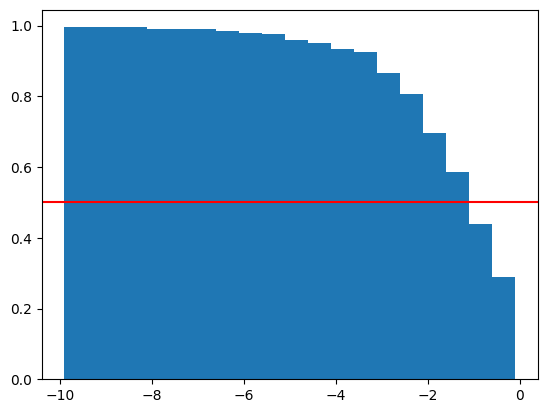

In [115]:
def find_dist(x):
    return price_df[price_df['drawdown'] > x].shape[0] / price_df.shape[0]

threshold_candidates = [i for i in np.arange(-0.5, -10.0, -0.5)]
dist = [find_dist(th) for th in threshold_candidates]
dist_df = pd.DataFrame(zip(threshold_candidates, dist))
dist_df.set_index(0)
plt.bar(x=dist_df[0], height=dist_df[1])
plt.axhline(0.5, c='red');
